# Урок 6. Feature Engineering, Feature Selection, part II

**Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.**


In [1]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [2]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    data = pd.read_csv(csv_path)
    data.columns=[col.lower() for col in data.columns]
    print("shape = {} rows, {} cols".format(*data.shape))
    return data

In [3]:
train = load_data("assignment_2_train.csv")
test = load_data("assignment_2_test.csv")

shape = 180000 rows, 394 cols
shape = 100001 rows, 394 cols


In [4]:
train.describe()

,transactionid,isfraud,transactiondt,transactionamt,card1,card2,card3,card5,addr1,addr2,...,v330,v331,v332,v333,v334,v335,v336,v337,v338,v339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, transactionid to v339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [6]:
train.head()

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,v330,v331,v332,v333,v334,v335,v336,v337,v338,v339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def target_description_print(ds, target_name):                              
    """
    Печать распределения целевых значений.
    
    Parameters
    ----------
    ds: pd.DataFrame
        Вектор целевой переменной.
    target_name: str
        название целевого поля
    """
    
    values_count_TARGET_0 = ds[ds[target_name]==0].count()[target_name]
    values_count_TARGET_1 = ds[ds[target_name]==1].count()[target_name]
    values_count_TARGET_1_2 = np.around(values_count_TARGET_1/values_count_TARGET_0,3)
    values_count_TARGET_Sum = values_count_TARGET_0+values_count_TARGET_1
    print("TARGET==0 values count =",values_count_TARGET_0)
    print("TARGET==1 values count =",values_count_TARGET_1)
    print("(TARGET==1)count / (TARGET==0)count =",values_count_TARGET_1_2)
    print("TARGET==0 and TARGET==1 in sum values count =",values_count_TARGET_Sum)

In [8]:
target_description_print(train,'isfraud')

TARGET==0 values count = 174859
TARGET==1 values count = 5141
(TARGET==1)count / (TARGET==0)count = 0.029
TARGET==0 and TARGET==1 in sum values count = 180000


In [9]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          cat_feats,
                          metric: callable,                          
                          cv_strategy,                          
                          isCatBoost=False
                          ):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        if isCatBoost:
            estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                          cat_features=cat_feats,plot=True)
        else:
            model.fit(X=x_train,y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=500,
                      eval_metric="auc",
                      verbose=200,
                      categorical_feature=cat_feats)
        
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [10]:
def set_date_columns(data,orig_date_col_name,base_dt_str):
    start_delta_sec = data[orig_date_col_name].min()
    base_date=pd.to_datetime(base_dt_str, infer_datetime_format=True)
    
    data["datetime_transactiondt"]=data[orig_date_col_name].apply(lambda x: base_date + pd.Timedelta(seconds=x))   
    data["year"] = data["datetime_transactiondt"].dt.year
    data["month_of_year"] = data["datetime_transactiondt"].dt.month    
    data["day_of_week"] = data["datetime_transactiondt"].dt.weekday
    data["hour"] = data["datetime_transactiondt"].dt.hour
    data["day"] = data["datetime_transactiondt"].dt.day

In [11]:
def concatenate(row,col_list):
    tmp=''
    for col_name in col_list:
        if not np.isnan(row[col_name]):           
            tmp=tmp+str(int(row[col_name]))
    
    new_col_name = tmp
    return new_col_name

In [12]:
def set_concat_features(ds,lists_table_columns,concatenate:callable):
    for columns_list in lists_table_columns:
        new_col_name=''
        for column in columns_list:            
            new_col_name+=(column+"_")
        ds[new_col_name]=ds.apply(lambda row:concatenate(row,columns_list),axis=1)

In [13]:
lists_table_columns=[["card1", "card2"],["card1", "card2","card3", "card5"],["card1", "card2","card3", "card5","addr1", "addr2"]]

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

In [15]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__( self, feature_names):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 
    
    def fit_transform( self, X, y = None ):
        for feature_name in self._feature_names:
            X[feature_name]=X[feature_name].fillna(-1)            
            dt = (X.groupby(feature_name).size()) / len(X)            
            X[feature_name + "_encode"] = X[feature_name].apply(lambda x : dt[x])
        return X 
    

In [16]:
freqEncoder=FrequencyEncoder(["card1","card2","card3","card4","card5","card6", "addr1", "addr2"])

In [17]:
def create_features_for_ratio_value_stats_ver2(data: pd.DataFrame,
                                          groupby_ids: list,
                                          aggs: dict,
                                          stats_names: list,
                                          suffix: Optional[str] = '',
                                          ) -> pd.DataFrame:
    """
        Построение признаков как отношения целевого поля к отношению агрегаций для числовых признаков.
        версия 2
    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_ids: str
        Название ключей, по которым нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.
    
    stats_names: list
    имена статистик
 
    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    for feature_name,statistics in aggs.items():
        for groupby_id in groupby_ids:
            apps_groupby = data.groupby(groupby_id, as_index=False)
            app_stats = apps_groupby[feature_name].agg(statistics).reset_index()           
            app_stats[f"{feature_name}_{suffix}"]=app_stats.apply(lambda row: row[stats_names[0]]/row[stats_names[1]] if row[stats_names[1]]!=0 else row[stats_names[0]],axis=1)
            app_stats[f"{feature_name}_{suffix}"]=app_stats[f"{feature_name}_{suffix}"].apply(lambda x: x if x != 0 else 1)
            data = data.merge(app_stats, how="left", on=groupby_id)    
            
             
            data[f"{feature_name}_{groupby_id}_{suffix}"]=data.apply(lambda row:
                                                        float(row[feature_name])/float(row[f"{feature_name}_{suffix}"]),axis=1)

            data=data.drop(stats_names,axis=1)
            data=data.drop([f"{feature_name}_{suffix}"],axis=1)           

        
    return data
        

In [18]:
def set_int_fractional_parts_log_features(data: pd.DataFrame,
                                          feature_name: str,
                                          suffix: Optional[str] = ''
                                          ) -> pd.DataFrame:
    
    """
        Построение признаков путем выделения дробной части и целой части признака feature_name в 
        два отдельных признака. Также создать отдельных признак - логарифм от feature_name
    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения признаков.
        
    feature_name: str
    имя поля, для которого делаются доп признаки
 
    suffix: str
        Суффиксы для названия признаков.
        

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    
    data[feature_name]=data[feature_name].fillna(-1)
    #int part
    data[feature_name+"_int_"+suffix]=data[feature_name].apply(lambda x: int(x))
    #fractional part
    data[feature_name+"_fractional_"+suffix]=data[feature_name].apply(lambda x: x-int(x) if x > 0 else int(x)-x)
    #log 
    data[feature_name+"_log_"+suffix]=data[feature_name].apply(lambda x: np.log(x) if x > 0 else 0)
    
    return data


In [19]:
train["ISTEST"]=0

In [20]:
test["ISTEST"]=1

In [21]:
data=pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

In [22]:
set_date_columns(data,'transactiondt','2017-12-01')

In [23]:
set_concat_features(data,lists_table_columns,concatenate=concatenate)

In [24]:
data=freqEncoder.fit_transform(data)

In [25]:
aggs = {
    "transactionamt": [np.mean,np.std]   
}
stats_names = ['mean','std']

data = create_features_for_ratio_value_stats_ver2(
    data, groupby_ids=['card1','card2','card3','card4','card5','card6','addr1', 'addr2', 'card1_card2_', 'card1_card2_card3_card5_', 'card1_card2_card3_card5_addr1_addr2_'], aggs=aggs, stats_names=stats_names, suffix="ratio"
)


In [26]:
aggs = {
    "d15": [np.mean,np.std]   
}
stats_names = ['mean','std']

data = create_features_for_ratio_value_stats_ver2(
    data, groupby_ids=['card1','card2','card3','card4','card5','card6','addr1', 'addr2', 'card1_card2_', 'card1_card2_card3_card5_', 'card1_card2_card3_card5_addr1_addr2_'], aggs=aggs, stats_names=stats_names, suffix="ratio"
)


In [27]:
data=set_int_fractional_parts_log_features(data,'transactionamt')
data

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,d15_card5_ratio,d15_card6_ratio,d15_addr1_ratio,d15_addr2_ratio,d15_card1_card2__ratio,d15_card1_card2_card3_card5__ratio,d15_card1_card2_card3_card5_addr1_addr2__ratio,transactionamt_int_,transactionamt_fractional_,transactionamt_log_
0,2987000,0,86400,68.500,W,13926,-1.0,150.0,discover,142.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,68,0.500,4.226834
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29,0.000,3.367296
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,417.486201,376.310012,347.404026,360.257294,456.684575,456.684575,665.454071,59,0.000,4.077537
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,122.095805,132.604480,133.586247,126.947808,118.418034,118.418034,93.699371,50,0.000,3.912023
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,0.000,3.912023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279996,3386996,0,10091528,368.990,W,13964,496.0,150.0,mastercard,224.0,...,756.918828,690.499006,709.246713,661.043542,603.471422,603.471422,614.510907,368,0.990,5.910770
279997,3386997,0,10091533,445.330,W,10616,583.0,150.0,visa,226.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,445,0.330,6.098816
279998,3386998,0,10091544,15.226,C,9803,583.0,150.0,visa,226.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,0.226,2.723004
279999,3386999,0,10091549,34.742,C,16062,500.0,185.0,mastercard,137.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34,0.742,3.547949


In [28]:
data.shape

(280001, 437)

In [29]:
data["datetime_transactiondt"]=data["datetime_transactiondt"].dt.strftime('%Y-%m-%d-%H:%M:%S')

In [30]:
mask=data["ISTEST"]==1
feature_to_drop=["transactionid","transactiondt","isfraud","ISTEST"]
train,test=data.loc[~mask],data.loc[mask]

target=train["isfraud"]
target_test=test["isfraud"]

train=train.drop(feature_to_drop,axis=1)
test=test.drop(feature_to_drop,axis=1)

categorical = train.dtypes[train.dtypes=="object"].index.tolist()
numerical=list(set(train.columns)-set(categorical))

train=train.replace(np.inf,np.nan)
train=train.replace(-np.inf,np.nan)

In [31]:
for c in categorical:
    train[c] = train[c].astype('category')

In [32]:
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "n_jobs": 8,
    "seed": 27,
    "early_stopping_rounds":500,
    'num_leaves': 50,
    'max_depth': 9,
    'subsample_for_bin': 200000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
}

In [33]:
model = lgb.LGBMClassifier(**lgbm_params)

In [34]:
cv_strategy = KFold(n_splits=5, random_state=42,shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model, categorical, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.967624	valid_1's auc: 0.93337
[400]	training's auc: 0.982739	valid_1's auc: 0.947708
[600]	training's auc: 0.989605	valid_1's auc: 0.953982
[800]	training's auc: 0.993143	valid_1's auc: 0.957909
[1000]	training's auc: 0.995861	valid_1's auc: 0.961987
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.8944, valid-score = 0.798


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.968201	valid_1's auc: 0.927153
[400]	training's auc: 0.982158	valid_1's auc: 0.935943
[600]	training's auc: 0.988741	valid_1's auc: 0.938919
[800]	training's auc: 0.992956	valid_1's auc: 0.942231
[1000]	training's auc: 0.995185	valid_1's auc: 0.943267
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.8934, valid-score = 0.7941


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.966344	valid_1's auc: 0.933552
[400]	training's auc: 0.981437	valid_1's auc: 0.945355
[600]	training's auc: 0.989067	valid_1's auc: 0.95093
[800]	training's auc: 0.992597	valid_1's auc: 0.953865
[1000]	training's auc: 0.995593	valid_1's auc: 0.955456
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.8928, valid-score = 0.8061


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.968097	valid_1's auc: 0.925072
[400]	training's auc: 0.982922	valid_1's auc: 0.941471
[600]	training's auc: 0.989886	valid_1's auc: 0.94796
[800]	training's auc: 0.992951	valid_1's auc: 0.950522
[1000]	training's auc: 0.995662	valid_1's auc: 0.951994
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8961, valid-score = 0.7968


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.966948	valid_1's auc: 0.941252
[400]	training's auc: 0.98283	valid_1's auc: 0.954961
[600]	training's auc: 0.989892	valid_1's auc: 0.960108
[800]	training's auc: 0.993433	valid_1's auc: 0.963119
[1000]	training's auc: 0.995665	valid_1's auc: 0.964841
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.894, valid-score = 0.7932
CV-results train: 0.8942 +/- 0.001
CV-results valid: 0.7976 +/- 0.005
OOF-score = 0.7976


In [35]:
model=estimators[4] #берем лучшую модель Fold: 5

In [36]:
for c in categorical:
    test[c] = test[c].astype('category')

In [37]:
test_predict_proba=model.predict_proba(test)[:,1]  

In [38]:
test_roc_auc=roc_auc_score(target_test,test_predict_proba)
test_roc_auc

0.8430045456797727

**Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

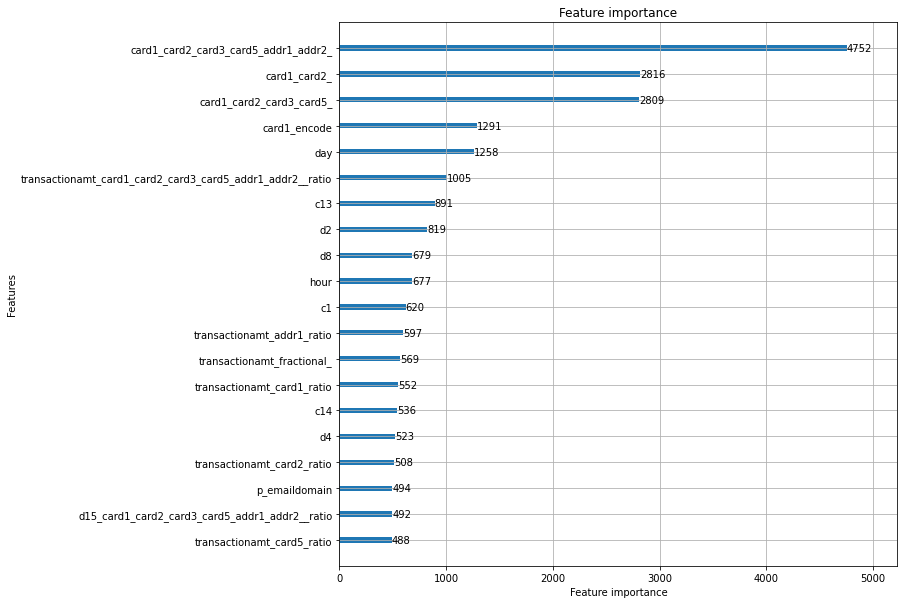

In [39]:
lgb.plot_importance(model,max_num_features=20,figsize=(10,10))

In [69]:
features=train.columns       


In [75]:
def get_features_importance_data(features, estimators):  
    columns=[]
    for i,estimator in enumerate(estimators):
        columns.append(f"estimator_{i}")
    features_importance_data = pd.DataFrame(index=features,columns=columns)


    for i,feature in enumerate(features):
        for j,estimator in enumerate(estimators):
            features_importance_data.loc[feature][f"estimator_{j}"]=estimator.feature_importances_[i]
            
    features_importance_data["MEAN"]=features_importance_data.mean(axis=1)
    features_importance_data=features_importance_data.sort_values(by="MEAN",ascending=False)
    
    return features_importance_data
        
    

In [95]:
initial_features_importance_data=get_features_importance_data(features, estimators)

In [96]:
initial_features_importance_data.head(20)

,estimator_0,estimator_1,estimator_2,estimator_3,estimator_4,MEAN
card1_card2_card3_card5_addr1_addr2_,4752,4752,4752,4752,4752,4752.0
card1_card2_,2816,2816,2816,2816,2816,2816.0
card1_card2_card3_card5_,2809,2809,2809,2809,2809,2809.0
card1_encode,1291,1291,1291,1291,1291,1291.0
day,1258,1258,1258,1258,1258,1258.0
transactionamt_card1_card2_card3_card5_addr1_addr2__ratio,1005,1005,1005,1005,1005,1005.0
c13,891,891,891,891,891,891.0
d2,819,819,819,819,819,819.0
d8,679,679,679,679,679,679.0
hour,677,677,677,677,677,677.0


Text(0.5, 1.0, 'Внутренний способ для оценки важности признаков алгоритма')

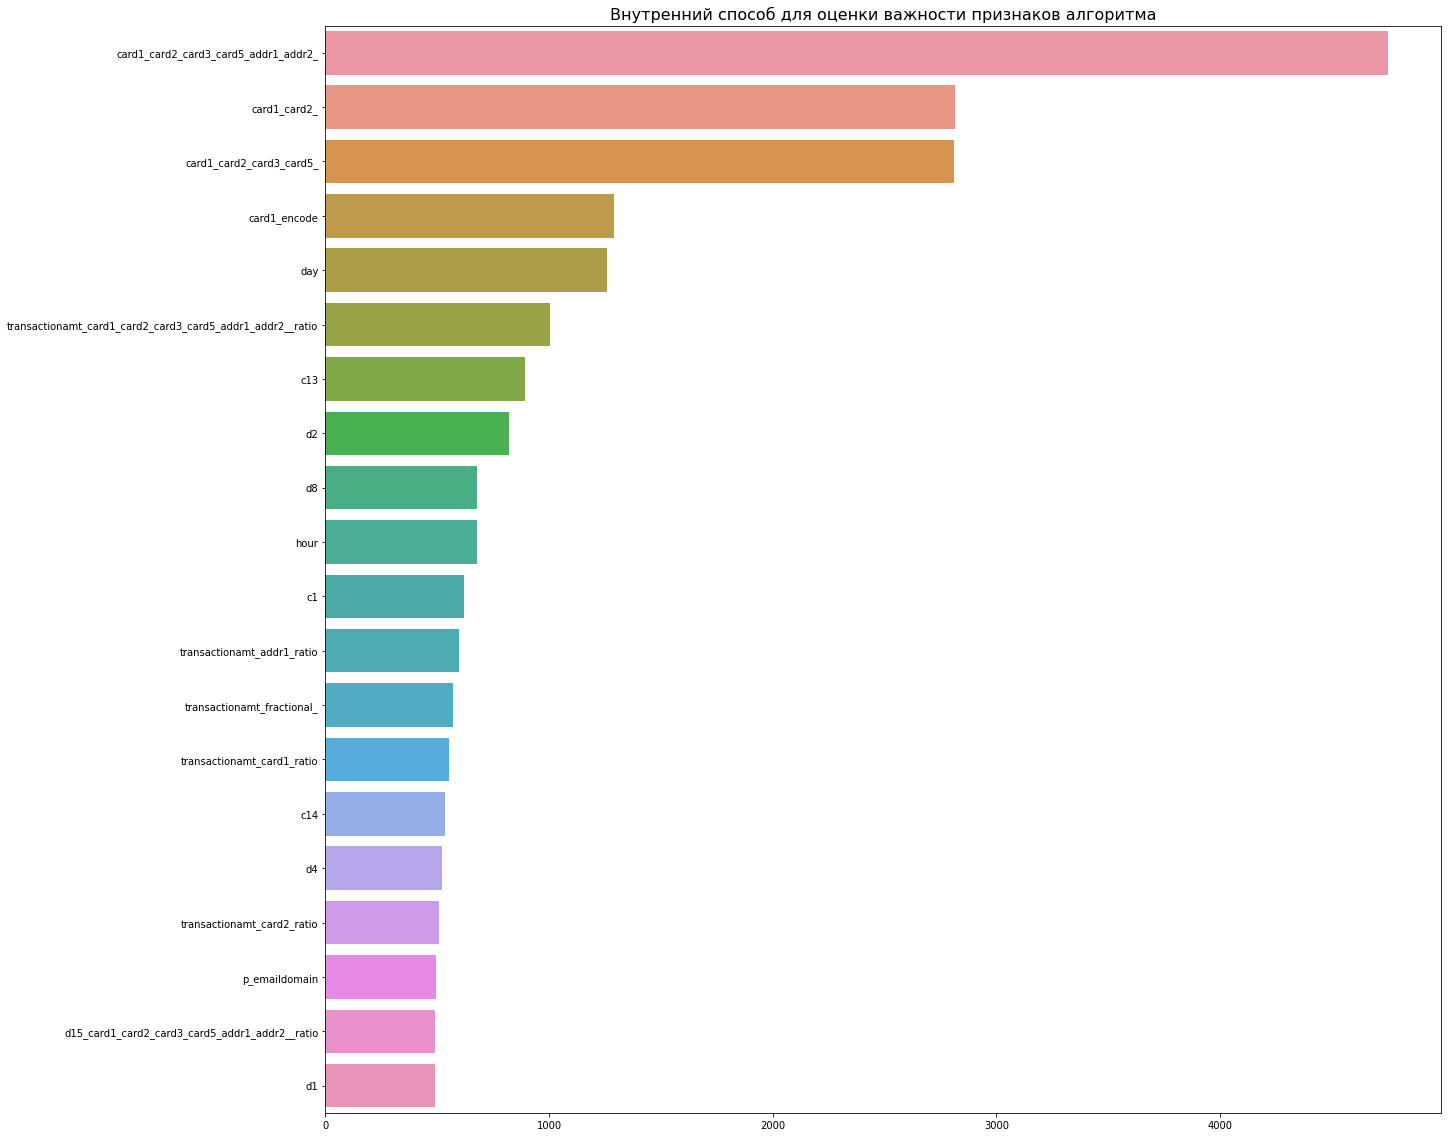

In [97]:
plt.figure(figsize=(20,20))
sns.barplot(y=initial_features_importance_data.index.to_list()[:20],x=initial_features_importance_data.iloc[:20,:].MEAN.values)
plt.title("Внутренний способ для оценки важности признаков алгоритма",size=16)

**Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.**

берем признаки, которые  по важности менее важные в 100 раз чем максимума и большие по этому показателю

In [98]:
mask=(initial_features_importance_data.MEAN >= initial_features_importance_data.MEAN.max()/100)

In [99]:
features_importance_data=initial_features_importance_data[mask].sort_values(by="MEAN",ascending=False)

In [100]:
features_importance_data

,estimator_0,estimator_1,estimator_2,estimator_3,estimator_4,MEAN
card1_card2_card3_card5_addr1_addr2_,4752,4752,4752,4752,4752,4752.0
card1_card2_,2816,2816,2816,2816,2816,2816.0
card1_card2_card3_card5_,2809,2809,2809,2809,2809,2809.0
card1_encode,1291,1291,1291,1291,1291,1291.0
day,1258,1258,1258,1258,1258,1258.0
...,...,...,...,...,...,...
v128,49,49,49,49,49,49.0
m9,49,49,49,49,49,49.0
v90,49,49,49,49,49,49.0
v309,48,48,48,48,48,48.0


In [104]:
train1=pd.DataFrame(train,columns=features_importance_data.index)

In [105]:
train1

,card1_card2_card3_card5_addr1_addr2_,card1_card2_,card1_card2_card3_card5_,card1_encode,day,transactionamt_card1_card2_card3_card5_addr1_addr2__ratio,c13,d2,d8,hour,...,v280,v66,v223,v48,v37,v128,m9,v90,v309,v187
0,1392615014231587,13926,13926150142,0.000079,2,NaN,1.0,NaN,NaN,0,...,0.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,275540415010232587,2755404,2755404150102,0.001236,2,64.765665,1.0,NaN,NaN,0,...,0.0,1.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,NaN
2,466349015016633087,4663490,4663490150166,0.001643,2,15.227272,1.0,NaN,NaN,0,...,0.0,1.0,NaN,0.0,1.0,0.0,F,0.0,0.0,NaN
3,1813256715011747687,18132567,18132567150117,0.006807,2,131.779184,25.0,112.0,NaN,0,...,28.0,1.0,NaN,0.0,1.0,925.0,NaN,0.0,0.0,NaN
4,449751415010242087,4497514,4497514150102,0.000021,2,NaN,1.0,NaN,NaN,0,...,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,187731015022427287,1877310,1877310150224,0.000132,15,51.722849,5.0,20.0,NaN,19,...,1.0,1.0,NaN,0.0,1.0,29.0,NaN,0.0,0.0,NaN
179996,1007551415022431587,10075514,10075514150224,0.000464,15,115.571164,16.0,239.0,NaN,19,...,0.0,1.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,NaN
179997,605312215019533087,6053122,6053122150195,0.001218,15,31.881230,1.0,NaN,NaN,19,...,0.0,1.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,NaN
179998,772655515022627287,7726555,7726555150226,0.000021,15,14.832045,24.0,361.0,NaN,19,...,2.0,1.0,NaN,NaN,NaN,112.0,NaN,0.0,0.0,NaN


In [107]:
test1=pd.DataFrame(test,columns=features_importance_data.index)

In [108]:
test1

,card1_card2_card3_card5_addr1_addr2_,card1_card2_,card1_card2_card3_card5_,card1_encode,day,transactionamt_card1_card2_card3_card5_addr1_addr2__ratio,c13,d2,d8,hour,...,v280,v66,v223,v48,v37,v128,m9,v90,v309,v187
180000,1247355515022629987,12473555,12473555150226,0.000118,24,63.124113,6.0,4.0,NaN,19,...,14.0,1.0,NaN,0.0,2.0,1482.000000,T,0.0,0.0000,NaN
180001,1565141715022633087,15651417,15651417150226,0.002475,24,5195.595606,1.0,NaN,NaN,19,...,1.0,1.0,NaN,1.0,1.0,0.000000,NaN,1.0,0.0000,NaN
180002,1384458315022612687,13844583,13844583150226,0.001089,24,285.950256,1.0,NaN,NaN,19,...,1.0,1.0,NaN,1.0,1.0,319.950012,T,1.0,0.0000,NaN
180003,1155630915022618187,11556309,11556309150226,0.000143,24,273.186162,2.0,6.0,NaN,19,...,1.0,1.0,NaN,0.0,1.0,59.000000,T,0.0,0.0000,NaN
180004,1098555515022623187,10985555,10985555150226,0.000039,24,98.898336,10.0,NaN,NaN,19,...,0.0,1.0,NaN,1.0,1.0,0.000000,T,1.0,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279996,1396449615022429987,13964496,13964496150224,0.000686,27,741.030379,12.0,154.0,NaN,19,...,1.0,1.0,NaN,1.0,1.0,368.989990,T,1.0,0.0000,NaN
279997,1061658315022647287,10616583,10616583150226,0.009664,27,373.102611,0.0,NaN,NaN,19,...,0.0,1.0,NaN,1.0,1.0,0.000000,NaN,1.0,0.0000,NaN
279998,9803583150226,9803583,9803583150226,0.003121,27,8.361838,1.0,0.0,88.791664,19,...,1.0,1.0,1.0,0.0,1.0,15.225800,NaN,0.0,15.2258,1.0
279999,1606250018513728460,16062500,16062500185137,0.001825,27,19.682830,2.0,NaN,NaN,19,...,0.0,1.0,NaN,0.0,1.0,0.000000,NaN,0.0,0.0000,NaN


In [111]:
categorical1 = train1.dtypes[train1.dtypes=="object"].index.tolist()
numerical1=list(set(train1.columns)-set(categorical1))

In [112]:
for c in categorical1:
    train1[c] = train1[c].astype('category')

In [113]:
for c in categorical1:
    test1[c] = test1[c].astype('category')

In [114]:
model = lgb.LGBMClassifier(**lgbm_params)

In [116]:
cv_strategy = KFold(n_splits=5, random_state=42,shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train1, target, model, categorical1, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.929975	valid_1's auc: 0.911087
[400]	training's auc: 0.951946	valid_1's auc: 0.926471
[600]	training's auc: 0.966317	valid_1's auc: 0.936285
[800]	training's auc: 0.974905	valid_1's auc: 0.942284
[1000]	training's auc: 0.981117	valid_1's auc: 0.946309
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.8057, valid-score = 0.7563


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.929321	valid_1's auc: 0.916214
[400]	training's auc: 0.955121	valid_1's auc: 0.929284
[600]	training's auc: 0.96784	valid_1's auc: 0.935729
[800]	training's auc: 0.975411	valid_1's auc: 0.939455
[1000]	training's auc: 0.981012	valid_1's auc: 0.942325
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.8011, valid-score = 0.7586


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.929457	valid_1's auc: 0.914955
[400]	training's auc: 0.95337	valid_1's auc: 0.931359
[600]	training's auc: 0.967017	valid_1's auc: 0.939584
[800]	training's auc: 0.974808	valid_1's auc: 0.945021
[1000]	training's auc: 0.980167	valid_1's auc: 0.948673
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.8008, valid-score = 0.7442


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.928816	valid_1's auc: 0.905535
[400]	training's auc: 0.954453	valid_1's auc: 0.925623
[600]	training's auc: 0.967931	valid_1's auc: 0.936167
[800]	training's auc: 0.97638	valid_1's auc: 0.942606
[1000]	training's auc: 0.981559	valid_1's auc: 0.946309
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8051, valid-score = 0.75


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.928462	valid_1's auc: 0.917574
[400]	training's auc: 0.952892	valid_1's auc: 0.934241
[600]	training's auc: 0.966926	valid_1's auc: 0.942833
[800]	training's auc: 0.975073	valid_1's auc: 0.948336
[1000]	training's auc: 0.980904	valid_1's auc: 0.952433
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.8059, valid-score = 0.7519
CV-results train: 0.8037 +/- 0.002
CV-results valid: 0.7522 +/- 0.005
OOF-score = 0.7521


In [117]:
model=estimators[4] #берем лучшую модель Fold: 5

In [118]:
test_predict_proba1=model.predict_proba(test1)[:,1]  

In [119]:
test_roc_auc=roc_auc_score(target_test,test_predict_proba1)
test_roc_auc

0.8811951780688566

Выводы: по сравнению с базовым значением метрики=0.843 выигрыш почти на 0.04 или на 4,5 %

**Задание 3: использовать permutation importance, выполнить задание 1 и 2.**

используем кастомизированную реализация permutation_importance

In [48]:
model=estimators[4]

In [61]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     categorical: list,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])
        
        if(feature in categorical):
            x_valid_[feature] = x_valid_[feature].astype('category')
            

        y_pred = _predict(estimator, x_valid_)        
        
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [62]:
scores, importance = calculate_permutation_importance(
    model, roc_auc_score, train, target,categorical
)

100%|██████████| 433/433 [59:51<00:00,  8.29s/it]


In [63]:
features=train.columns 

In [64]:
def get_permutation_features_importance_data(features, model):  
    columns=['best_estimator']    
    features_importance_data = pd.DataFrame(index=features,columns=columns)          
    features_importance_data.loc[:,"best_estimator"]=importance          
    features_importance_data=features_importance_data.sort_values(by="best_estimator",ascending=False)    
    return features_importance_data

In [65]:
initial_features_importance_data=get_permutation_features_importance_data(features, model)

In [66]:
initial_features_importance_data

,best_estimator
card1_card2_card3_card5_addr1_addr2_,0.014999
card1_encode,0.003779
p_emaildomain,0.002213
card1_card2_card3_card5_,0.002086
day,0.001976
...,...
v102,-0.000029
v188,-0.000040
c12,-0.000086
c8,-0.000089


Text(0.5, 1.0, 'Permutation importance способ для оценки важности признаков алгоритма')

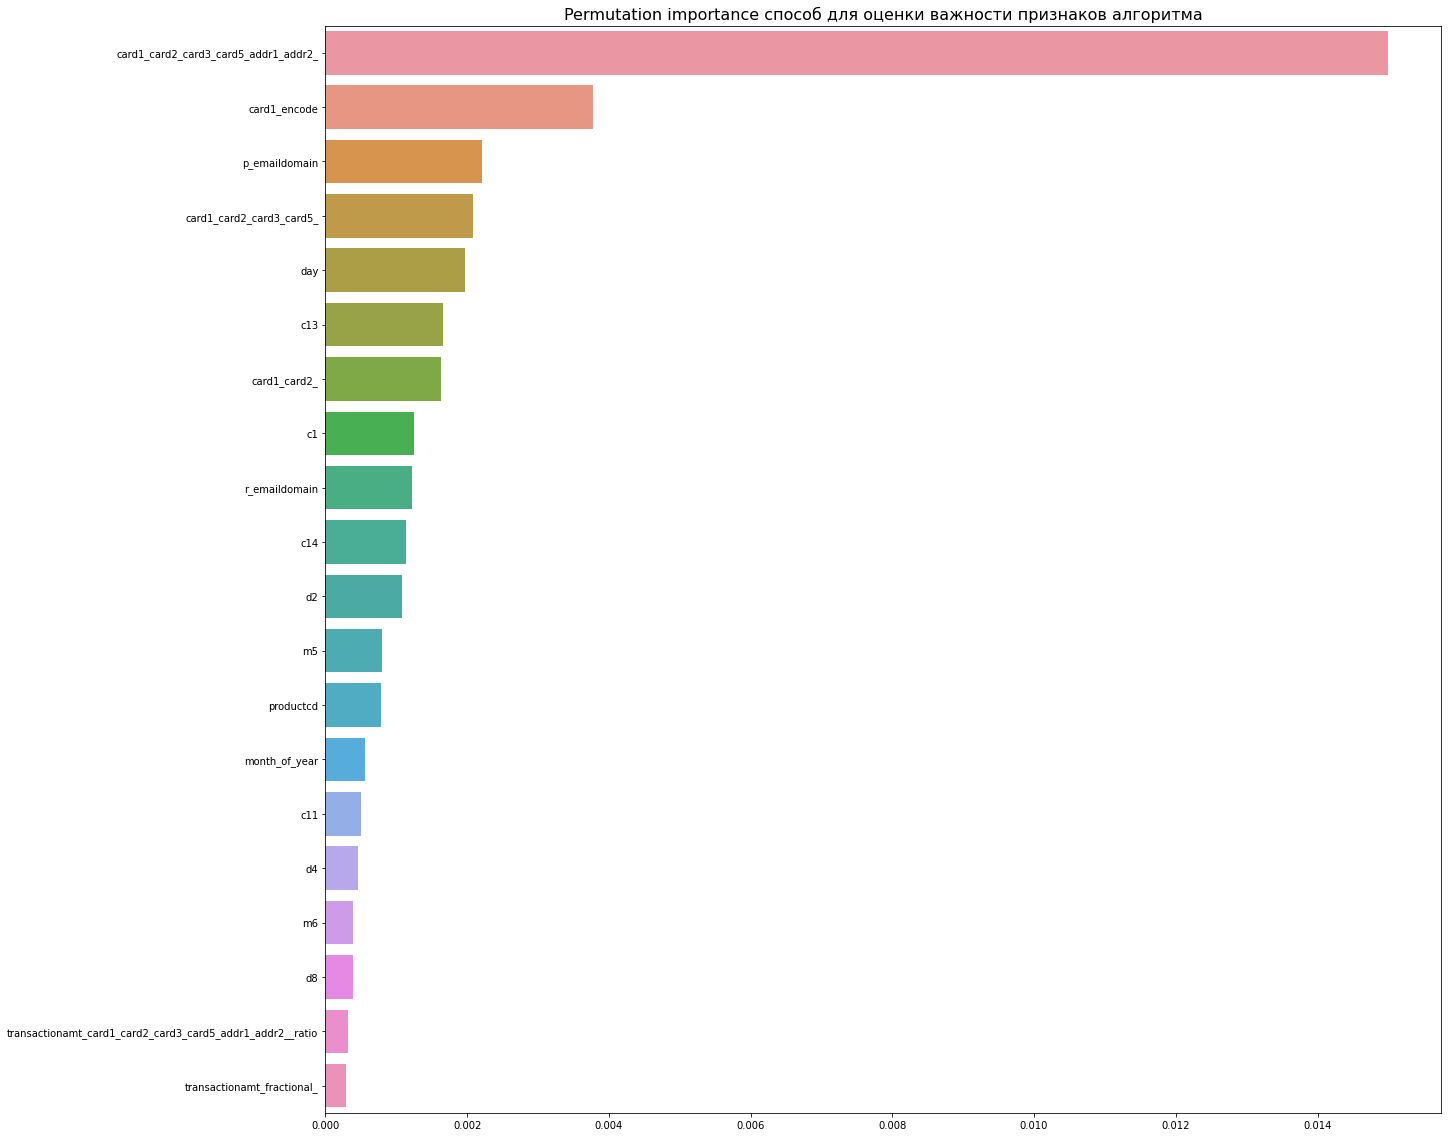

In [67]:
plt.figure(figsize=(20,20))
sns.barplot(y=initial_features_importance_data.index.to_list()[:20],x=initial_features_importance_data.iloc[:20,:].best_estimator.values)
plt.title("Permutation importance способ для оценки важности признаков алгоритма",size=16)

In [68]:
mask=(initial_features_importance_data.best_estimator >= initial_features_importance_data.best_estimator.max()/100)

In [69]:
features_importance_data=initial_features_importance_data[mask].sort_values(by="best_estimator",ascending=False)

In [70]:
train2=pd.DataFrame(train,columns=features_importance_data.index)

In [71]:
test2=pd.DataFrame(test,columns=features_importance_data.index)

In [72]:
categorical2 = train2.dtypes[train2.dtypes=="object"].index.tolist()
numerical2=list(set(train2.columns)-set(categorical2))

In [73]:
for c in categorical2:
    train2[c] = train2[c].astype('category')
for c in categorical2:
    test2[c] = test2[c].astype('category')

In [74]:
model = lgb.LGBMClassifier(**lgbm_params)

In [75]:
cv_strategy = KFold(n_splits=5, random_state=42,shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train2, target, model, categorical2, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.929732	valid_1's auc: 0.913192
[400]	training's auc: 0.948524	valid_1's auc: 0.926566
[600]	training's auc: 0.960984	valid_1's auc: 0.934346
[800]	training's auc: 0.969582	valid_1's auc: 0.939218
[1000]	training's auc: 0.975898	valid_1's auc: 0.941935
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.7692, valid-score = 0.7246
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.927889	valid_1's auc: 0.914684
[400]	training's auc: 0.950007	valid_1's auc: 0.926792
[600]	training's auc: 0.962676	valid_1's auc: 0.932282
[800]	training's auc: 0.970473	valid_1's auc: 0.935211
[1000]	training's auc: 0.97693	valid_1's auc: 0.937214
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.7625, valid-score = 0.7284
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.927627	valid_1's auc: 0.91579
[400]	training's auc: 0.94816	valid_1's auc: 0.927812
[600]	training's auc: 0.960911	valid_1's auc: 0.93451
[800]	training's auc: 0.969402	valid_1's auc: 0.938843
[1000]	training's auc: 0.975596	valid_1's auc: 0.942312
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.7685, valid-score = 0.725
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.928081	valid_1's auc: 0.904185
[400]	training's auc: 0.949363	valid_1's auc: 0.921626
[600]	training's auc: 0.961586	valid_1's auc: 0.929958
[800]	training's auc: 0.969856	valid_1's auc: 0.935199
[1000]	training's auc: 0.976364	valid_1's auc: 0.938778
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.7685, valid-score = 0.7237
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.927716	valid_1's auc: 0.915276
[400]	training's auc: 0.94819	valid_1's auc: 0.929014
[600]	training's auc: 0.961038	valid_1's auc: 0.935951
[800]	training's auc: 0.969464	valid_1's auc: 0.940051
[1000]	training's auc: 0.975751	valid_1's auc: 0.943332
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.7704, valid-score = 0.7242
CV-results train: 0.7678 +/- 0.003
CV-results valid: 0.7252 +/- 0.002
OOF-score = 0.7252


In [76]:
model=estimators[4] #берем лучшую модель Fold: 5

In [77]:
test_predict_proba2=model.predict_proba(test2)[:,1]  

In [78]:
test_roc_auc=roc_auc_score(target_test,test_predict_proba2)
test_roc_auc

0.8656600760901325

Выводы: по сравнению с базовым значением метрики=0.843 выигрыш почти на 0.022 или на 2,6 %, однако хуже чем при использовании встроенной в модель метрики 0.881

**Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.**

In [39]:
!pip install boostaroota

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [40]:
from boostaroota import BoostARoota

In [41]:
#x_train = pd.get_dummies(train, columns=categorical)

In [44]:
br = BoostARoota(metric='auc', clf=lgb, iters=2,max_rounds=10, cutoff=2)
br.fit(train, target)

AttributeError: module 'lightgbm' has no attribute 'fit'

Выводы: BoostARoota с моделью lightgbm не работает

**Задание 5: использовать shap, выполнить задание 1 и 2.**

In [39]:
!pip install shap

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [40]:
import shap

In [41]:
features=train.columns 

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train, target)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [51]:
def get_shap_features_importance_data(features, model):  
    columns=['best_estimator']    
    features_importance_data = pd.DataFrame(index=features,columns=columns)          
    features_importance_data.loc[:,"best_estimator"]= np.median(shap_values[:][:][0],axis=0)        
    features_importance_data=features_importance_data.sort_values(by="best_estimator",ascending=False)    
    return features_importance_data

In [52]:
initial_features_importance_data=get_shap_features_importance_data(features, model)

In [53]:
initial_features_importance_data

,best_estimator
card1_card2_card3_card5_addr1_addr2_,0.260399
card1_card2_card3_card5_,0.083262
card1_card2_,0.081983
c1,0.061156
r_emaildomain,0.054339
...,...
productcd,-0.050409
c13,-0.054018
day,-0.060871
d2,-0.063584


Text(0.5, 1.0, 'shap importance способ для оценки важности признаков алгоритма')

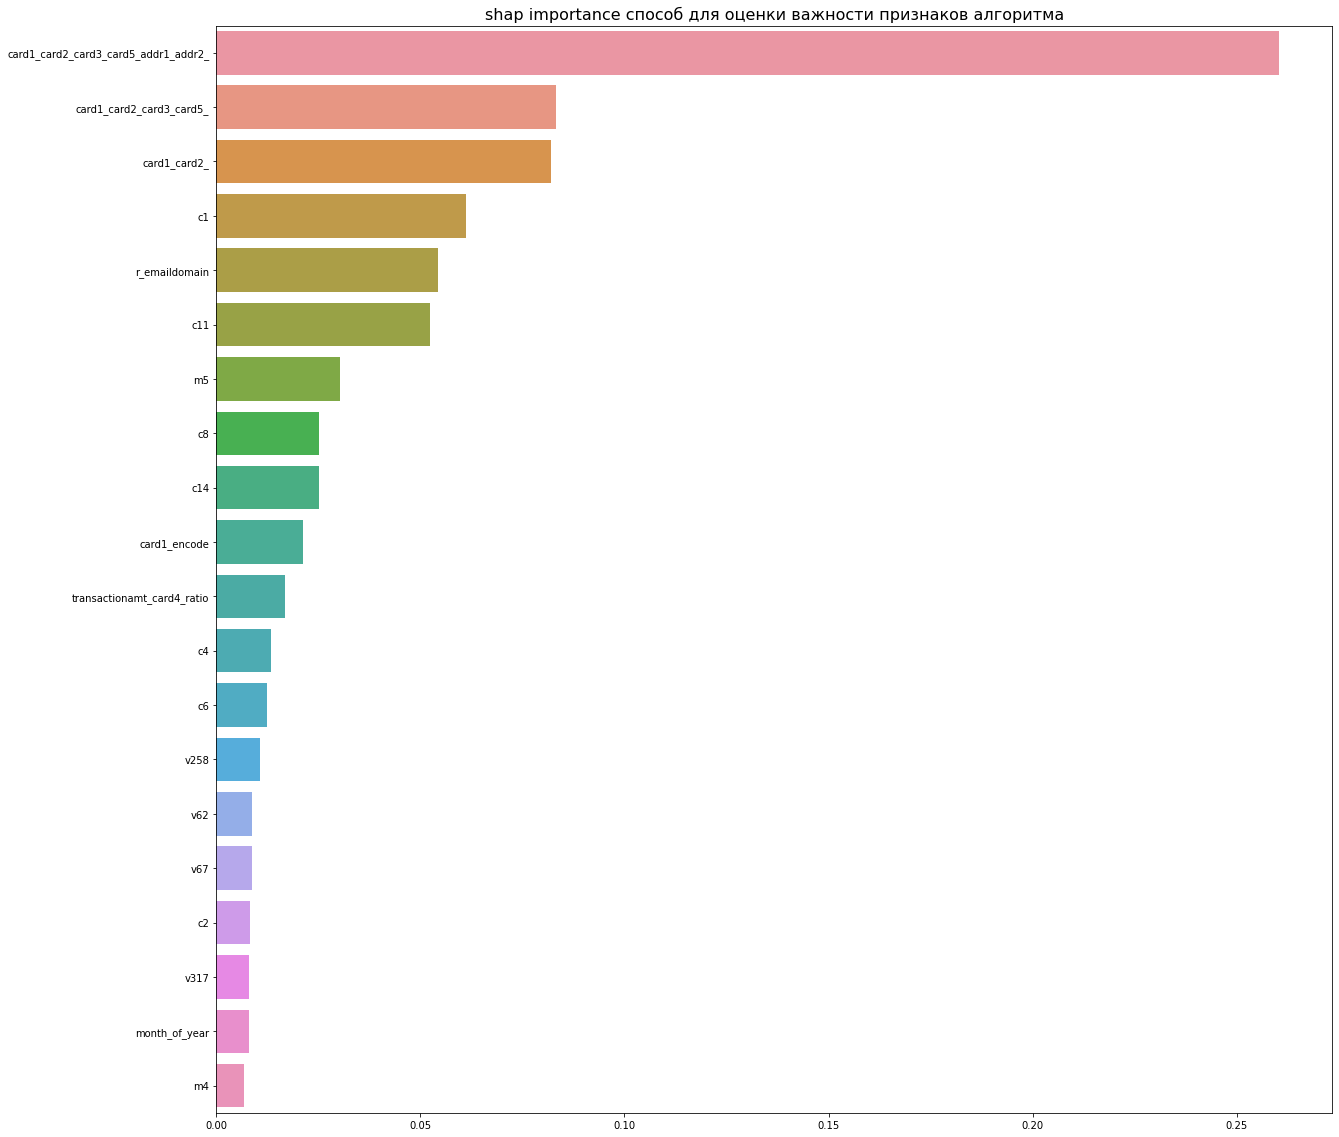

In [54]:
plt.figure(figsize=(20,20))
sns.barplot(y=initial_features_importance_data.index.to_list()[:20],x=initial_features_importance_data.iloc[:20,:].best_estimator.values)
plt.title("shap importance способ для оценки важности признаков алгоритма",size=16)

In [243]:
mask=(initial_features_importance_data.best_estimator >= initial_features_importance_data.best_estimator.max()/100)

In [244]:
features_importance_data=initial_features_importance_data[mask].sort_values(by="best_estimator",ascending=False)

In [245]:
test4=pd.DataFrame(test,columns=features_importance_data.index)

In [248]:
train4=pd.DataFrame(train,columns=features_importance_data.index)

In [249]:
categorical4 = train4.dtypes[train4.dtypes=="object"].index.tolist()
numerical4=list(set(train4.columns)-set(categorical4))

In [250]:
for c in categorical4:
    train4[c] = train4[c].astype('category')
for c in categorical4:
    test4[c] = test4[c].astype('category')

In [251]:
model = lgb.LGBMClassifier(**lgbm_params)

In [252]:
cv_strategy = KFold(n_splits=5, random_state=42,shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train4, target, model, categorical4, metric=roc_auc_score,cv_strategy=cv_strategy
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.918354	valid_1's auc: 0.901952
[400]	training's auc: 0.93595	valid_1's auc: 0.914967
[600]	training's auc: 0.946943	valid_1's auc: 0.921976
[800]	training's auc: 0.955239	valid_1's auc: 0.926811
[1000]	training's auc: 0.962401	valid_1's auc: 0.930376
Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.7666, valid-score = 0.7245
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


[200]	training's auc: 0.916761	valid_1's auc: 0.905717
[400]	training's auc: 0.937001	valid_1's auc: 0.915132
[600]	training's auc: 0.948946	valid_1's auc: 0.920256
[800]	training's auc: 0.957195	valid_1's auc: 0.923419
[1000]	training's auc: 0.964478	valid_1's auc: 0.926361
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.763, valid-score = 0.7352


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500
[200]	training's auc: 0.917055	valid_1's auc: 0.907258
[400]	training's auc: 0.935538	valid_1's auc: 0.91972
[600]	training's auc: 0.94738	valid_1's auc: 0.926559
[800]	training's auc: 0.956192	valid_1's auc: 0.931336
[1000]	training's auc: 0.962535	valid_1's auc: 0.933978
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.7637, valid-score = 0.717
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


[200]	training's auc: 0.918577	valid_1's auc: 0.897049
[400]	training's auc: 0.93747	valid_1's auc: 0.912773
[600]	training's auc: 0.948772	valid_1's auc: 0.920351
[800]	training's auc: 0.95732	valid_1's auc: 0.926144
[1000]	training's auc: 0.96387	valid_1's auc: 0.929855
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.7697, valid-score = 0.7294
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


[200]	training's auc: 0.916425	valid_1's auc: 0.906409
[400]	training's auc: 0.935423	valid_1's auc: 0.920485
[600]	training's auc: 0.946875	valid_1's auc: 0.927766
[800]	training's auc: 0.955473	valid_1's auc: 0.932605
[1000]	training's auc: 0.963018	valid_1's auc: 0.936969
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.7675, valid-score = 0.7317
CV-results train: 0.7661 +/- 0.002
CV-results valid: 0.7276 +/- 0.006
OOF-score = 0.7277


In [253]:
model=estimators[4] #берем лучшую модель Fold: 5

In [254]:
test_predict_proba4=model.predict_proba(test4)[:,1]  

In [255]:
test_roc_auc=roc_auc_score(target_test,test_predict_proba4)
test_roc_auc

0.8699036025103017

Выводы: по сравнению с базовым значением метрики=0.843 выигрыш почти на 0.027 или на 3,2 %, однако хуже чем при использовании встроенной в модель метрики 0.881

**Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.**

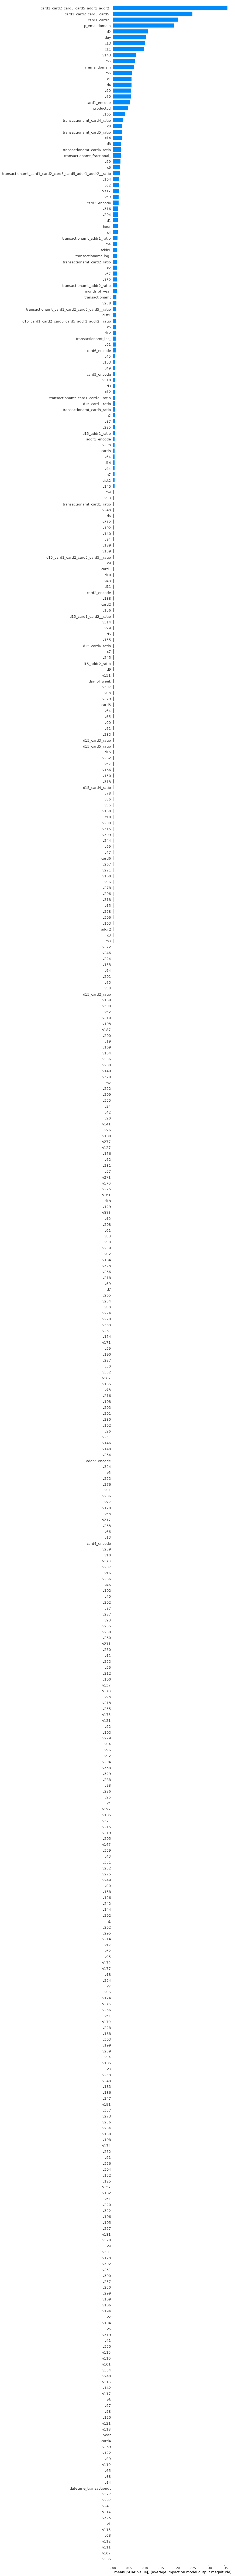

In [60]:
shap.summary_plot(shap_values, train, plot_type="bar", max_display=train.shape[1])

In [55]:
import warnings

In [57]:

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)

features = train.iloc[select]
features_display = train.loc[features.index]


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    #shap_interaction_values = explainer.shap_interaction_values(features)
#if isinstance(shap_interaction_values, list):
#    shap_interaction_values = shap_interaction_values[1]



Explainer expected value: -5.59898844858444


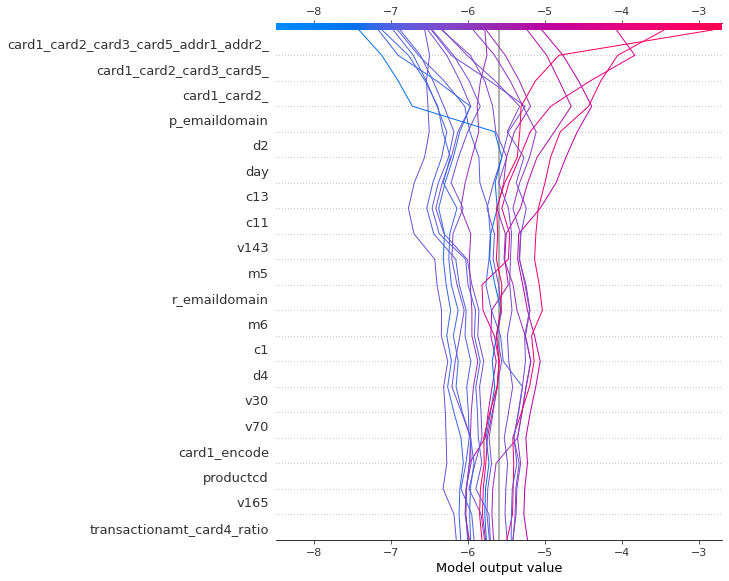

In [59]:
shap.decision_plot(expected_value, shap_values, features_display)

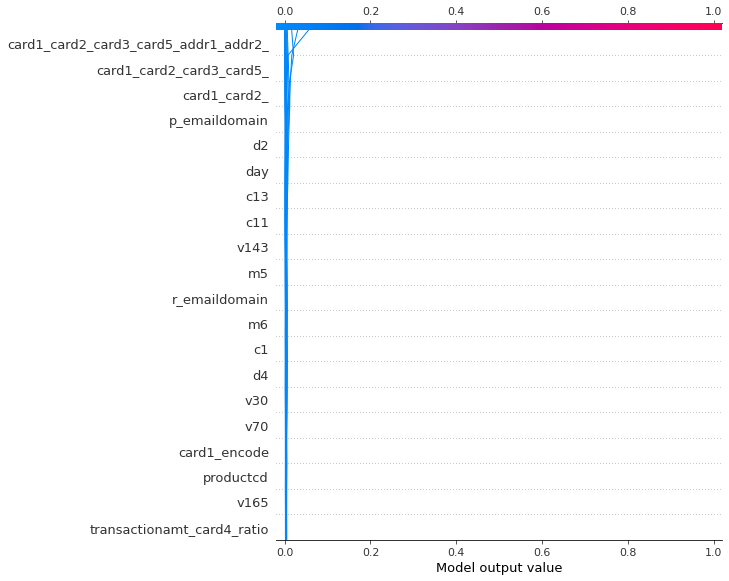

In [64]:
shap.decision_plot(expected_value, shap_values, features_display, link="logit")

Выводы: По графикам выше можно заключить, что наибольшее влияние на прогноз оказывают признаки начиная с  p_emaildomain и выше по важности.